# Exercises 4

*Antti Härkönen*

## 1.

The Monty Hall problem can be interpreted as a collider as following:

A = the contestant's first pick

B = the door with the car

C = the door opened by the host

A and B are independent, but C is dependent on both A and B, since the host will not open the door with car behind it
or the door selected first.

The contestant observes both A and C, but B is a hidden variable that must be determined.

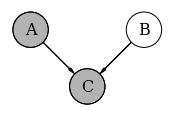

In [1]:
import daft
from matplotlib import rc

rc("font", family="serif", size=16)
scale = 1.25
pgm = daft.PGM()

pgm.add_node('A', 'A', 1, 1, scale=scale, observed=True)
pgm.add_node('B', 'B', 3, 1, scale=scale)
pgm.add_node('C', 'C', 2, 0, scale=scale, observed=True)

pgm.add_edge('A', 'C', directed=True)
pgm.add_edge('B', 'C', directed=True)

pgm.render()

## 2.

## a)

{S, U}, {X, S}, {U, Y}, {X, T}, {X, U}, {X, V}, {X, Y}

## b)

{X, S}: {R}
{X, T}: {R}
{X, U}: {}
{X, V}: {}
{X, Y}: {}
{R, T}: {S}
{R, U}: {}
{R, V}: {}
{R, Y}: {}
{S, U}: {}
{S, V}: {}
{S, Y}: {}
{T, V}: {U}
{T, Y}: {V}
{U, Y}: {V}

## c)

Z can be one of the following: R, S, U, V

## 3.

$ E[\bf z] = \bf R^{-1} \begin{pmatrix} \bf \Lambda \mu - \bf A' \bf L b \\ \bf Lb \end{pmatrix} $

$ = \begin{pmatrix} \bf\Lambda^{-1} & \bf\Lambda^{-1}\bf A' \\ \bf A \bf\Lambda^{-1} & \bf L^{-1} + \bf A \bf\Lambda^{-1}\bf A' \end{pmatrix} \begin{pmatrix} \bf \Lambda \mu - \bf A' \bf L b \\ \bf Lb \end{pmatrix} $

$ = \begin{pmatrix} \bf\Lambda^{-1}(\bf \Lambda \mu - \bf A' \bf L b) + \bf\Lambda^{-1}\bf A' \bf L \bf b \\ \bf A \bf\Lambda^{-1}(\bf \Lambda \mu - \bf A' \bf L b) + (\bf L^{-1} + \bf A \bf\Lambda^{-1}\bf A') \bf L \bf b \end{pmatrix} $

$ = \begin{pmatrix} \bf\Lambda^{-1}\bf \Lambda \mu - \bf\Lambda^{-1}\bf A' \bf L b + \bf\Lambda^{-1}\bf A' \bf L \bf b \\ \bf A \bf\Lambda^{-1}\bf \Lambda \mu - \bf A \bf\Lambda^{-1} \bf A' \bf L b + \bf L^{-1} \bf L \bf b + \bf A \bf\Lambda^{-1}\bf A' \bf L \bf b \end{pmatrix} $

$ = \begin{pmatrix} \bf\Lambda^{-1}\bf \Lambda \mu \\ \bf A \bf\Lambda^{-1}\bf \Lambda \mu + \bf L^{-1} \bf L \bf b \end{pmatrix} $

$ = \begin{pmatrix} \bf \mu \\ \bf A \bf \mu + \bf b \end{pmatrix} $

This means that $\mu_x$ and $\mu_y$ are linearly dependant.

## 4.

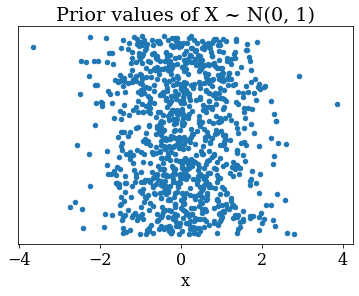

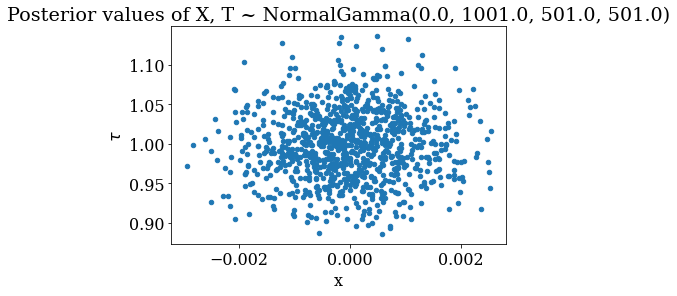

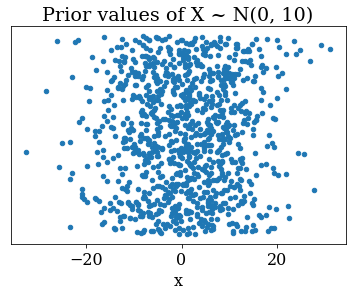

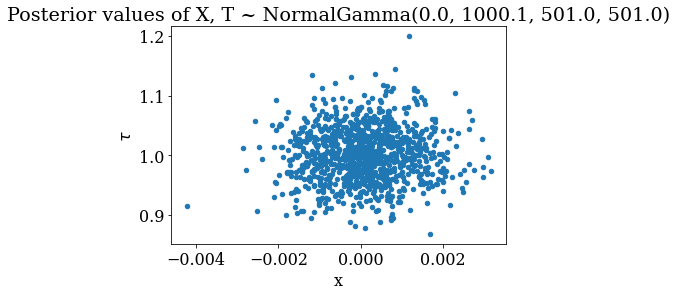

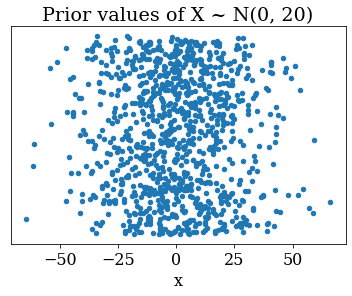

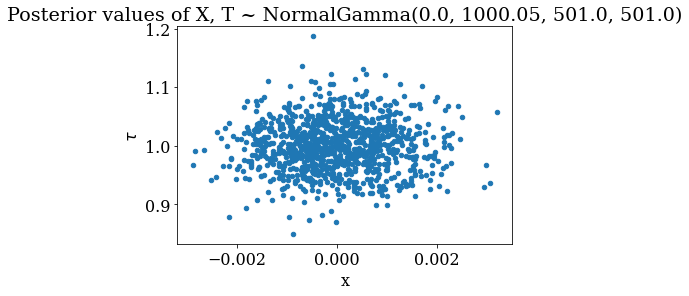

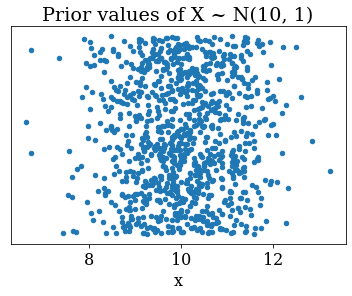

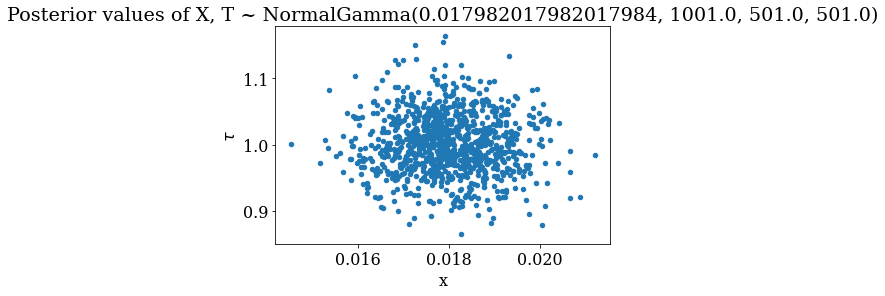

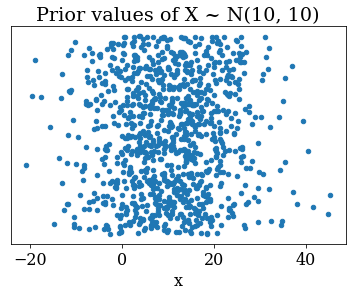

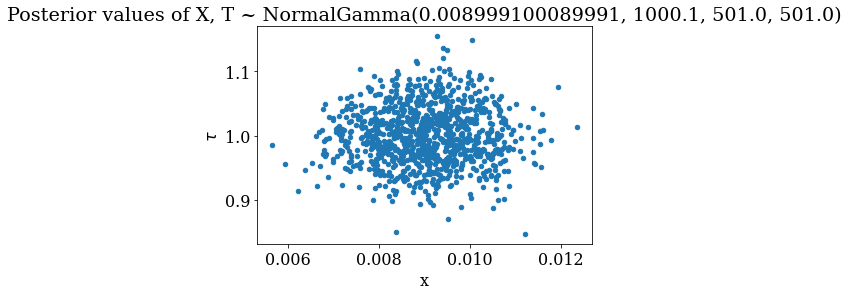

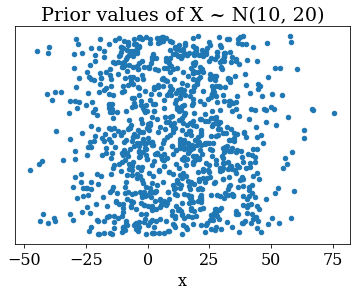

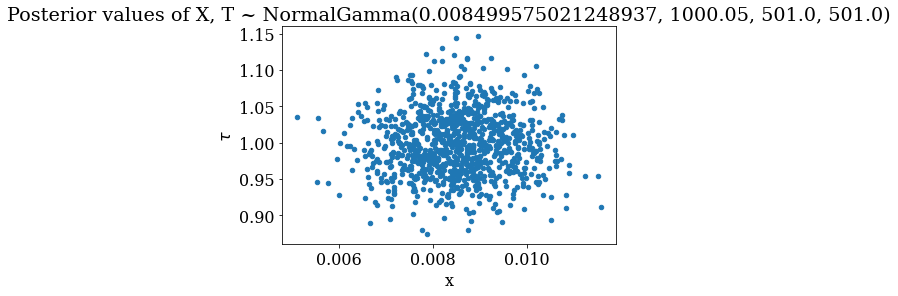

In [4]:
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow_probability.python.internal import samplers
import tensorflow_probability as tfp
tfd = tfp.distributions


class NormalGamma(tfd.Distribution):
    def __init__(
            self,
            mean,
            precision,
            alpha,
            beta,
    ):
        super().__init__(
            allow_nan_stats=True,
            dtype=None,
            reparameterization_type=tfd.FULLY_REPARAMETERIZED,
            validate_args=False,
        )
        self.mean = mean
        self.precision = precision
        self.alpha = alpha
        self.beta = beta

    def _sample_n(self, n, seed=None, **kwargs):
        tau = samplers.gamma((n, 1), self.alpha, self.beta, seed=seed).numpy()
        x = samplers.normal((n, 1), self.mean, 1 / (self.precision * tau)).numpy()
        sample = np.concatenate([x, tau], axis=1)
        return tf.constant(sample, dtype=sample.dtype)


means = 0, 10
variances = 1, 10, 20
n_samples = 1000,
s = 0.8

for mu_0, var_0, n in product(means, variances, n_samples):
    lam_0 = 1 / var_0
    prior_sample = tfd.Normal(mu_0, var_0).sample(n).numpy()
    prior_sample = pd.DataFrame({'x': prior_sample, 'offset': np.random.uniform(1, 1.1, size=n)})
    fig_prior = prior_sample.plot(x='x', y='offset', kind='scatter')
    fig_prior.get_yaxis().set_visible(False)
    fig_prior.set_title(f"Prior values of X ~ N({mu_0}, {var_0})")

    mu, precision = (lam_0 * mu_0 + s * mu_0) / (lam_0 + n), lam_0 + n
    alpha, beta = 1 + n/2, 1 + (n * 1) / 2
    posterior_sample = NormalGamma(mu, precision, alpha, beta).sample(n).numpy()
    posterior_sample = pd.DataFrame(posterior_sample, columns=['x', 'tau'])
    fig_posterior = posterior_sample.plot(x='x', y='tau', kind='scatter')
    fig_posterior.set_ylabel(r'$\tau$')
    fig_posterior.set_title(f"Posterior values of X, T ~ NormalGamma({mu}, {precision}, {alpha}, {beta})")
    plt.show()